<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/Clustering_earthquakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering (Earthquakes dataset)

In [ ]:
! pip install bds_courseware

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install plotly

In [ ]:
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy
import random
import warnings
import math
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.cm as cm
import plotly
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS, cluster_optics_dbscan
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples

from yellowbrick.cluster import SilhouetteVisualizer
import scipy.cluster.hierarchy as shc

from sklearn.model_selection import GridSearchCV

### Auxiliary functions

In [ ]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""
    # create the counts of samples under each node
    plt.figure(figsize=(30, 20))
    plt.title('Hierarchical Clustering Dendrogram')

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
    counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.xticks(fontsize=20, rotation=70)
    plt.show()

In [ ]:
def get_cartesian(lat=None,lon=None):
  # return cartesian coordinates by given latitude/longtitude
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 6371 # radius of the earth
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    return x,y,z

In [ ]:
def get_lat_lon(x=None,y=None,z=None):
  # return latitude/longtitude by given cartesian coordinates
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 6371 # radius of the earth
    lat = np.arcsin(z/R)
    lon = np.arctan2(y,x)

    lat, lon = np.rad2deg(lat), np.rad2deg(lon)
    return lat, lon

In [ ]:
def elbow(X):
  # elbow method of finding optimal K for K-Means
  kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
  }

  sse = []
  for k in range(1, 11):
      kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
      kmeans.fit(X)
      sse.append(kmeans.inertia_)

  k = [i*100 for i in np.diff(sse,2)].index(min([i*100 for i in np.diff(sse,2)]))

  plt.style.use("fivethirtyeight")
  fig, ax = plt.subplots()
  ax.plot(range(1, 11), sse)
 # ax.axvline(k, ls='--', color="red", label="k = "+str(k))
  plt.xticks(range(1, 11))
  plt.title('Optimal number of clusters(Elbow method')
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")
  plt.tight_layout()
  plt.show()

In [ ]:
def kmean_clustering(df, num):
  # Perform K-Means Clustering with given number of clusters
  model = KMeans(n_clusters=num, init='k-means++', n_init=10, max_iter=300, random_state=42)

  df_X = pd.DataFrame(df)
  cluster = model.fit_predict(df_X)
  ## find real centroids
  closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, df_X.values)

  return model, cluster

In [ ]:
def vizualize_clusters(df, method, **kwargs):
  # Plot Magnitude-Depth Scatterplot & visualize cluster on the Earth map
  X = df.copy()

  k = kwargs.pop('k', 0)
  epsilon = kwargs.pop('eps', 0)
  min_smpl = kwargs.pop('min_s', 0)

  if method == 'kmeans':
    m_name = 'K-Means'
    info_part = '(k='+str(k)+')'
  elif method == 'dbscan':
    m_name = 'DBSCAN'
    k = len(set(X.cluster)) - (1 if -1 in X.cluster else 0)
    info_part = f'(Epsilon = {epsilon}, Min Sample = {min_smpl}, Number of clusters = {k}'
  elif method == 'agg':
    m_name = 'Agglomerative'
    info_part = '(k='+str(k)+')'
  title=f'{m_name} Clustering {info_part}'

  size = round(X['Richter'] - X['Richter'].min() + 0.1, 2)

  X["cluster"] = X["cluster"].astype(str)

  # generate normally distributed samples
  sigma = 0.01
  noise = sigma * np.random.randn(len(X))
  X['Richter_w_noise'] = X['Richter'] + noise
  fig= px.scatter(X, x='Richter_w_noise', y='Depth',
            color='cluster', size=size, template='none', opacity=0.8,  title=title)
  fig.show()


  fig = px.scatter_geo(X, lon='Longitude', lat='Latitude',
           color='cluster', size=size, title='Map view',
           hover_data=df.columns, template='none',
           height=700, width=1000)
  fig.show()

In [ ]:
def cluster_stat(X):
  # Calculate number of elements, average depth, magnitude and coordinates for all obtained clusters
  clusters_df = pd.DataFrame(columns = ['id', 'quakes_qty', 'avg_depth', 'avg_magnitude', 'avg_lat', 'avg_lon'])
  for clust_number in set(X["cluster"]):
      clust_set = X[X.cluster == clust_number]
      if clust_number != -1:
          clusters_df = clusters_df.append({'id' : clust_number, "quakes_qty": clust_set.shape[0], 'avg_depth' : np.mean(clust_set.Depth), 'avg_magnitude' : np.mean(clust_set.Richter),
                                            'avg_lat' : np.mean(clust_set.Latitude),'avg_lon' : np.mean(clust_set.Longitude)}, ignore_index = True)
  clusters_df['id'] = clusters_df['id'].astype(int)
  clusters_df['quakes_qty'] = clusters_df['quakes_qty'].astype(int)
  return clusters_df

### EDA

Loading the data:

In [ ]:
print("Dataset names: ", HOMEWORK_DATASETS.keys())
name = "quake"
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
print(df.head(2))
print(df.shape)

Dataset names:  dict_keys(['suicide_rates', 'car_perfs', 'brain', 'bank', 'air_quality', 'hypothyroid', 'movies', 'bike_sharing_day', 'bike_sharing_hour', 'quake'])
   Focal depth  Latitude  Longitude  Richter
0           33    -52.26      28.30      6.7
1           36     45.53     150.93      5.8
(2178, 4)


In [ ]:
df.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


In [ ]:
df.describe()

,Focal depth,Latitude,Longitude,Richter
count,2178.000000,2178.000000,2178.000000,2178.000000
mean,74.359963,7.961997,54.914835,5.977181
std,116.467797,30.545583,118.875581,0.189426
min,0.000000,-66.490000,-179.960000,5.800000
25%,21.000000,-12.432500,-67.782500,5.800000
50%,39.000000,0.210000,122.100000,5.900000
75%,68.000000,36.480000,146.860000,6.100000
max,656.000000,78.150000,180.000000,6.900000


We have been given a dataset of earthquakes that happened in some period of time all over the Earth. As features, we have Focal Depth in kilometers, Magnitude in Richters, and geo coordinates in Latitude and Longitude. Focal Depth varies between 0 and 656 km, and Magnitude (Richter) - between 5.8 and 6.9.

For convenience reasons I decided to rename "Focal Depth" feature to just "Depth":

In [ ]:
df.rename(columns={"Focal depth": "Depth"}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Depth      2178 non-null   int64  
 1   Latitude   2178 non-null   float64
 2   Longitude  2178 non-null   float64
 3   Richter    2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


In [ ]:
df['Depth'].value_counts()

0      145
33     121
10      61
45      40
43      36
      ... 
328      1
574      1
333      1
170      1
527      1
Name: Depth, Length: 312, dtype: int64

Let's look at the distributions of variables:

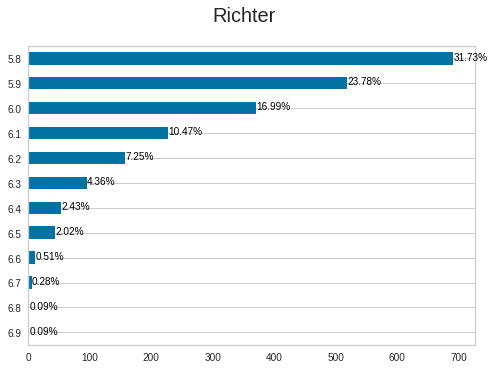

In [ ]:
x = "Richter"
ax = df[x].value_counts().sort_values().plot(kind="barh")
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20,
     str(round((i.get_width()/total)*100, 2))+'%',
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()

As we can see on the bar chart above from a magnitude perspective we have the most of datapoints (~ 72%) in the lowest category - 5.8 - 6.0 Richter, and another 27% - are earthquakes of moderate magnitude (6.1 - 6.5 Richter), and we have only about 1% of strong earthquakes with magnitude 6.6 - 6.9

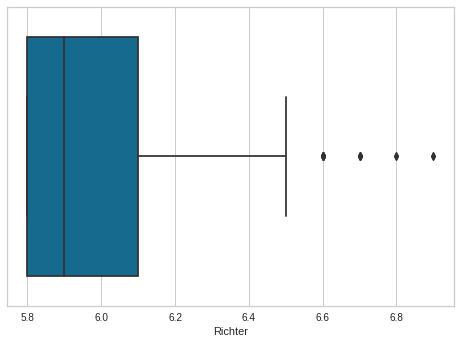

In [ ]:
sns.boxplot(x = 'Richter', data = df)
plt.show()

Boxplot for Richter feature shows a few of the strongest earthquakes as potential outliers as they lie beyond the upper whisker.  

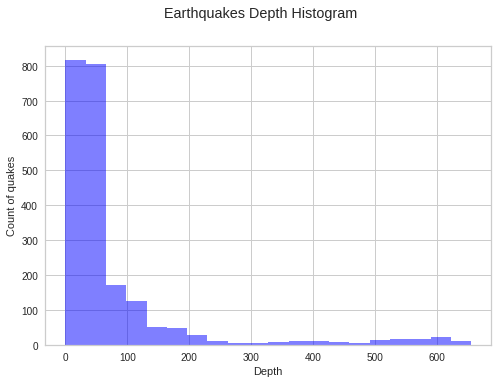

In [ ]:
fig, ax = plt.subplots()

ax.hist(df["Depth"], bins=20, alpha=0.5, color="blue")
ax.set_xlabel("Depth")
ax.set_ylabel("Count of quakes")
fig.suptitle("Earthquakes Depth Histogram")
ax.legend();

On the Depth histogram, we also see that the vast majority of earthquakes happened at the depth of 0 to 200 kilometers, and much less - deeper than 200-250 km.

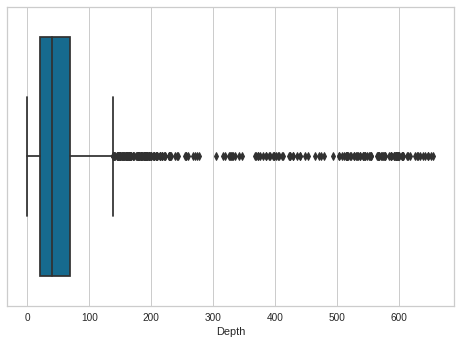

In [ ]:
sns.boxplot(x = 'Depth', data = df)
plt.show()

At the boxplot we see that the upper whisker (third quartile + 1.5 IQR) is even less than 250km, actually, it's at 140km approximately. So all the points up to this level are marked as potential outliers on the plot.

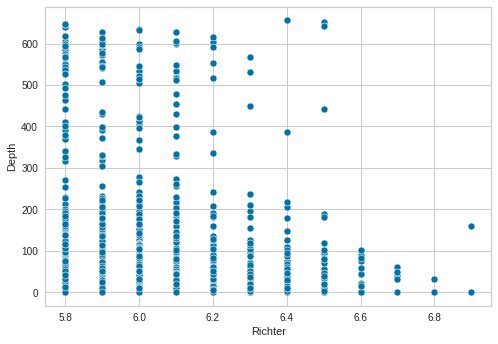

In [ ]:
sns.scatterplot(data=df, y="Depth", x="Richter")
plt.show()

Scatterplot above shows data points distributed over Depth and Magnitude. We can see here that the magnitude scale is not continuous in our case, it is discreet - we have only values aliquot to 0.1. We also can see that most of the deep earthquakes have low to moderate magnitude, and all of the strong earthquakes are shallow (below 100 km depth).

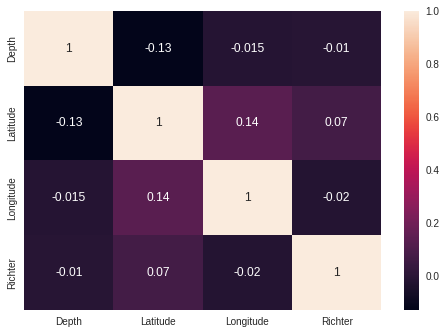

In [ ]:
corr = df.corr()
sns.heatmap(corr, annot=True);

On the heatmap, we see that there is no significant correlation between features.

## K-Means clusterization

#### Clusterization using only Depth and Magnitude features

First I decided to perform K-Means clustering over only two features - Depth and Magnitude. It will give me the intuition about what clusters can be in the context of only these two variables.

Defining a truncated dataset and standardizing variables so they are on the same scale because the K-Means algorithm is quite sensitive to it:

In [ ]:
X = df[["Depth","Richter"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Using the elbow (or inertia) method to determine the optimal number of clusters we need for our dataset. According to this method, we need to find the breaking point in the graph - the point where the direction of the plot changes drastically. In our case it is 3 or 4.

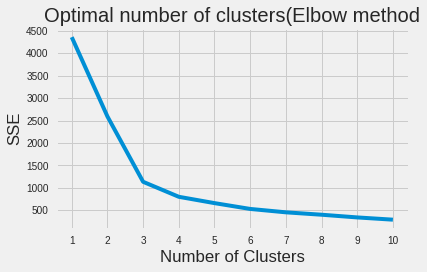

In [ ]:
elbow(X_scaled)

I chose 4 as an optimal number of clusters. Let's try to cluster data using K-Means:

In [ ]:
k = 4
kmeans, X["cluster"] = kmean_clustering(X_scaled, k)

In [ ]:
kmeans.cluster_centers_

array([[-0.22391907, -0.70834523],
       [-0.21218771,  0.50073345],
       [ 3.71183754, -0.07588321],
       [-0.20865964,  2.25064533]])

In [ ]:
kmeans.labels_

array([3, 0, 0, ..., 2, 1, 0], dtype=int32)

In [ ]:
X = X.join(df[['Longitude', 'Latitude']])
vizualize_clusters(X, 'kmeans', k=k)

Clusters interpritation:

*   Cluster 0: Shallow earthquake (up to 270m depth), low magnitude (up to 5.9)
*   Cluster 1: Shallow earthquake (up to 270m depth), moderate magnitude (6.0 - 6.2)
*   Cluster 2: Deep earthquake (270m to 700m depth), low to high magnitude (5.8 - 6.6)
*   Cluster 3: Shallow earthquake (up to 270m depth), moderate to high magnitude (6.3 - 6.9)





### K-Means using all features

**Feature engineering**

Using latitude and longitude in K-means clustering is not a good idea because K-means doesn't understand that -180 and +180 longitude - are the same meridian, from its point of view these are maximumly distanced one from another lines. This leads to dividing clusters located in this area into two different ones. In order to prevent this behavior I decided to convert latitude and longitude into Cartesian coordinates (x, y, z):     

In [ ]:
df['x'], df['y'], df['z'] = get_cartesian(df['Latitude'], df['Longitude'])

**Reducing dimentionality (PCA)**

In order to visualize the 4-dimensional space of features I'll perform a dimensionality reduction technic called PCA. Using it I will be able to reduce the number of features from 4 to 2 principal components which reflect most of the variance of the initial variables.

In [ ]:
columns_to_pca = ['Depth', 'Richter', 'Latitude', 'Longitude']

In [ ]:
columns_to_clusterize = ['x', 'y', 'z', 'Depth', 'Richter']

I tried different scaling algorithms and finally chose MinMaxScaler as it gives the maximum of explained variance with two PCA components, and also it gives a good picture of our space with clearly distinct clusters.

In [ ]:
X_pca = df[columns_to_pca]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
pca.explained_variance_ratio_.sum()

0.7250363656972433

In [ ]:
pca = PCA(n_components=0.95).fit(X_scaled)

len(pca.explained_variance_ratio_)

4

In [ ]:
X_pca['pca_x'], X_pca['pca_y'] = X_2d[:, 0], X_2d[:, 1]

In [ ]:
fig = px.scatter(X_pca, x='pca_x', y='pca_y', color='Richter', hover_data=X_pca.columns)
fig.update_layout(title='Earthquakes in 2d PCA space (Colored by Magnitude)')
fig.show()

Here on the plot, we can see several distinct clusters as well as bunches of highly dispersed points in between clusters.

So let's try to catch these clusters with K-Means. First, I am going to use K-Means with 15 clusters (as per the homework task). I also used MinMaxScaler as it gives better result than others.

In [ ]:
X = df.copy()
k = 15

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X[columns_to_clusterize])
X_scaled_df = pd.DataFrame(X_scaled, columns=columns_to_clusterize)

In [ ]:
kmeans, X["cluster"] = kmean_clustering(X_scaled_df, k)
X_pca["cluster"] = X["cluster"]

In [ ]:
fig = px.scatter(X_pca, x='pca_x', y='pca_y', color='cluster', hover_data=X_pca.columns)
fig.update_layout(title='Earthquakes in 2d PCA space (Cluster lables)')
fig.show()

On the PCA map, we see that K-Means gives quite satisfying results -  most groups of data points have been caught. However, the number of 15 clusters seems a bit excessive for our dataset, as we see some closely lying points were divided into separate clusters.

In [ ]:
vizualize_clusters(X, 'kmeans', k=k)

On the Earth map clustering for 15 clusters seems quite good, however, on the Depth-Magnitude plot it seems a bit messy (deep earthquakes are divided into 3 different clusters for example even though we have very few of them compared with shallow ones).

Again I'll use elbow method to determine the optimum number of clusters.

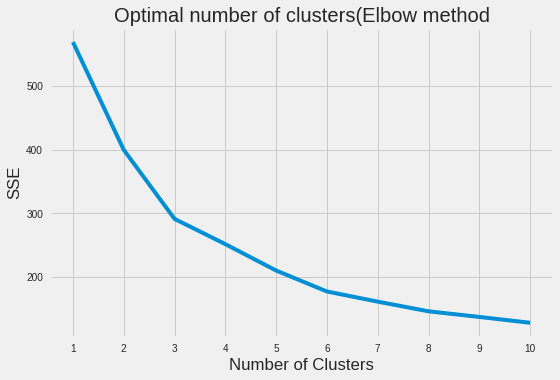

In [ ]:
elbow(X_scaled_df)

It gave something between 3 and 6. I decided to take 6.

###Silhouette Analysis

Another method of determining the optimal number of clusters is using the Silhouette Score - a measure of the separation distance between clusters. Below I'll draw Silhouette Plots for the range of possible numbers of clusters which represent clusters labels on the y-axis, while the actual Silhouette Score is on the x-axis. The size/thickness of the silhouettes is also proportional to the number of samples inside every cluster.

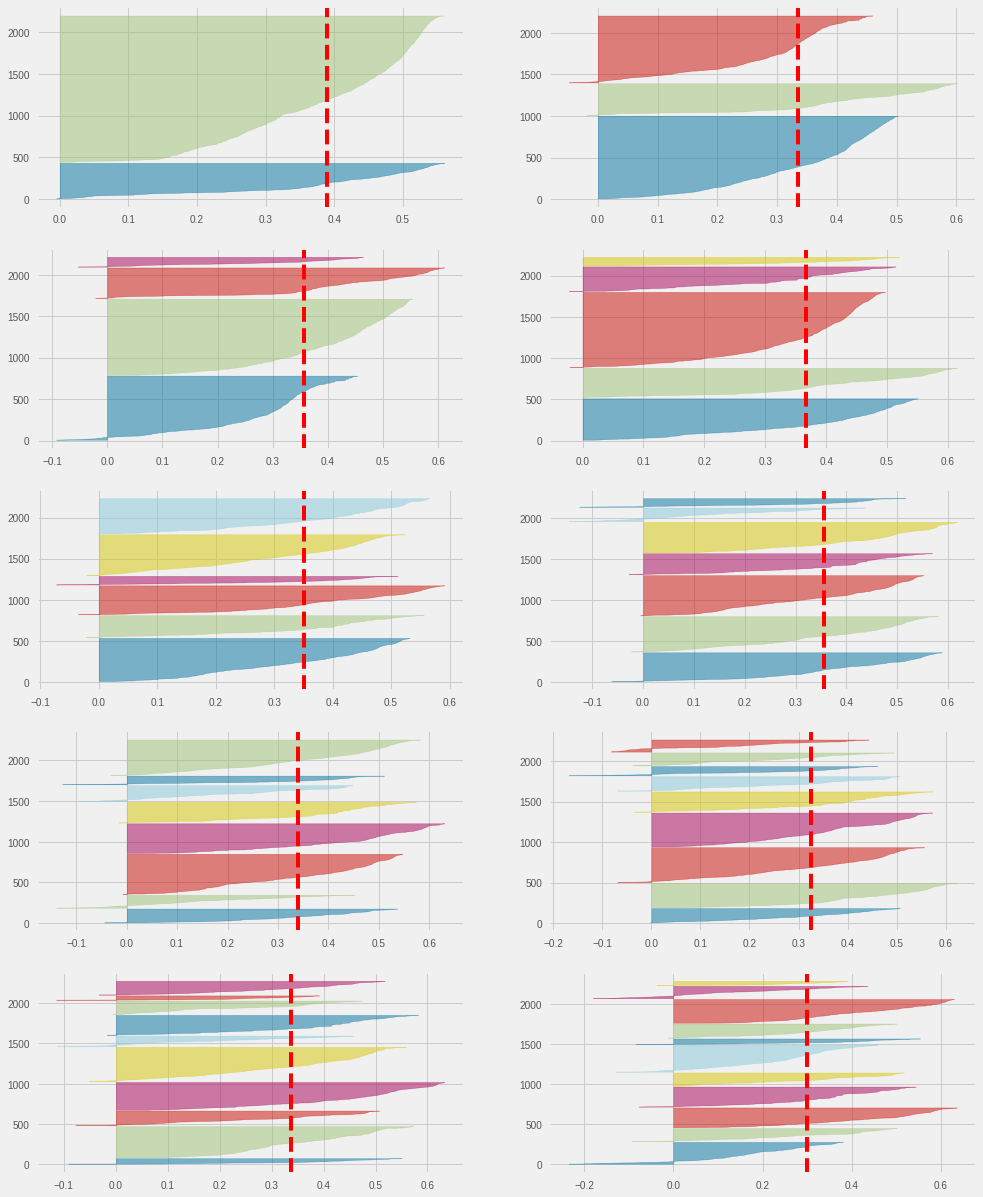

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(15,20))
for i in range(2,12):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled_df)

As we can see the highest Silhouette Score we obtain with k = 2, 4, and 5. However sizes of clusters in these cases are rather unbalanced - we get one major cluster at least twice greater than others, and on the other hand, a few clusters that are much thinner than others.  So I would like to stick with 6 as the cluster number as even if it's scoring a bit less the clusters we get are more balanced.

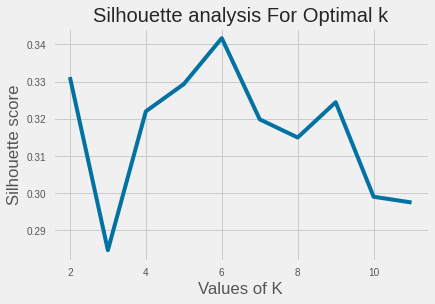

In [ ]:
range_n_clusters = range(2,12)
silhouette_avg = []
for num_clusters in range_n_clusters:
  # initialise kmeans
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X_scaled_df)
  cluster_labels = kmeans.labels_

  # silhouette score
  silhouette_avg.append(silhouette_score(X_scaled_df, cluster_labels))
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

Another plot shows the dependence of the Silhouette score and the number of clusters (K). Because the K-Means algorithm is stochastic it gives different results every run. So here on a plot k=6 option has definitely the maximum Silhouette score. So I'll go with 6 clusters.

### K-Means (k=6)

In [ ]:
X = df.copy()
k = 6

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[columns_to_clusterize])
X_scaled_df = pd.DataFrame(X_scaled, columns=[columns_to_clusterize])

In [ ]:
kmeans, X["cluster"] = kmean_clustering(X_scaled, k)
kmeans.cluster_centers_
X_pca["cluster"] = X["cluster"]

Below we can see visualization of obtained clusters in PCA space, in Depth-Magnitude space and on the Earth map:

In [ ]:
fig = px.scatter(X_pca, x='pca_x', y='pca_y', color='cluster', hover_data=X_pca.columns)
fig.update_layout(title='Earthquakes in 2d PCA space (Cluster lables)')
fig.show()

In [ ]:
vizualize_clusters(X, 'kmeans', k=k)

Clusters interpritation:

*   Cluster 0: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.6), South-West part of the Circum-Pacific belt (aka Ring of Fire) - Central and South America, South-East of Pacific Ocean, South of Atlantic Ocean.
*   Cluster 1: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.1), South-West part of the Ring of Fire - New Zeland, Okeania, Guinea, Indonesia, Phillipines, Australia.
*   Cluster 2: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.4), Europe, Central and South Asia, Middle East, Africa, North of the Atlantic Ocean, West of the Indian Ocean
*   Cluster 3: Deep earthquake (270m to 700m depth), low to high magnitude (5.8 - 6.6), Along the Ring of Fire mostly - South-West, West, North-West, and South East parts of the Pacific Ocean.
*   Cluster 4: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.2), North part of the Circum-Pacific belt - Japan, Kuril Islands, Kamchatka peninsula, Aleutian Islands, Alaska, West cost of Canada and USA.
*   Cluster 5: Shallow earthquake (up to 270m depth), moderate to high magnitude (6.2 - 6.7), All over the world.

Let's get a statistics for obtained clusters:

In [ ]:
cluster_stat(X)

,id,quakes_qty,avg_depth,avg_magnitude,avg_lat,avg_lon
0,0,338,50.905325,5.966568,-16.696213,-66.843077
1,1,774,58.762274,5.903876,-10.291357,94.529096
2,2,271,28.512915,5.956458,36.480443,63.071107
3,3,120,508.475000,5.962500,-0.361917,36.496500
4,4,419,41.157518,5.921002,43.783628,62.491599
5,5,256,51.871094,6.333594,10.788867,83.500469


We can see one cluster for deep earthquakes, one for strong ones, and other four with similar Depth/Magnitude characteristics but geografically spread.

Saving K-Means clusters labels in the base dataframe. Later I will use them as the ground truth labels in order to evaluate other clustering algorithms.

In [ ]:
df['kmeans_labels'] = X["cluster"]

### DBSCAN

Below I am going to use another clustering method - DBSCAN. It is density-based algorithm, that means that desicion of including a data point into the cluster based on the number of other points in the certain area around the data point. DBSCAN has two hyperparameters that greatly affect the outcome - epsilon (radius of the circle around the data point where density is measured), and min_sample - minimal number of data points in the area around currently estimated point needed to mark this point as core point in the certain cluster. I will need to determine the optimal values for these parameters.

Again I will use cartesian coordinates for clustering. Even though it is not necessery in case of DBSCAN (as this algorithm has embeded ability to work with Latitude and Longitude and interpret them properly), for me using cartesian coordinates gave better results.

In [ ]:
columns_to_clusterize = ['Depth', 'x', 'y', 'z', 'Richter']

In [ ]:
X = df.copy()

I haven't yet got intuition about which scaling method should be used for which aim, so I am simply went through them all and chose the one that gives the best result in terms of clustering. This way I chose MaxAbsScaler for DBSCAN clustering.

In [ ]:
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X[columns_to_clusterize])

We can estimate the optimal epsilon value by plotting distances between data points and it's closest neighbor points (found using NearestNeighbors). The optimal value for epsilon will be found at the point of maximum curvature of the plot.

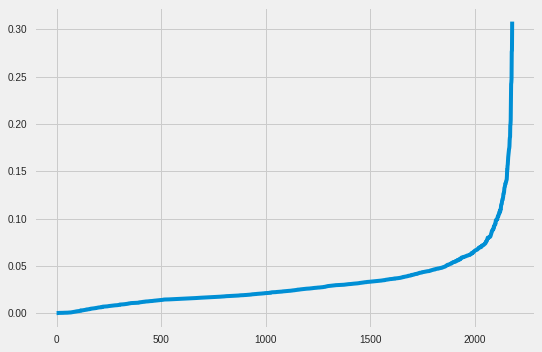

In [ ]:
neighbours = NearestNeighbors(n_neighbors=20)
nbrs = neighbours.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.grid(True)

In the plot above we can see that the interval of maximum curvature is between 0.05 and 0.15 along the y-axis. This interval contains the optimal value of epsilon, and I am going to find the precise value by finding the maximum value of the adjusted rand score. The metric to optimize might be a silhouette score also, but I chose supervised metric because one of the conditions we have is to compare model results with the ground truth which in our case is the K-Means label, so maximizing adjust rand index might make DBSCAN results better correspond with the ground truth.

The following code calculates adjust rand scores for epsilon values in the range between 0.12 and 0.2 with a step 0.01, and min_sample in the range between 2 and 32. Results are stored in an auxiliary data frame and then they are plotted on the graph.  

In [ ]:
def dbscan_hypers(eps, X, df):
  ms_range = range(2, 32)
  test_df = pd.DataFrame(columns=['min_sample','adj_rand'])
  for ms in ms_range:
    db = DBSCAN(eps=eps, min_samples=ms, metric='chebyshev').fit(X)
    labels = db.labels_
    labels_true = df['kmeans_labels']

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    adj_rand = metrics.adjusted_rand_score(labels_true, labels)
    silh = metrics.silhouette_score(X, labels)
    test_df = test_df.append({'min_sample' : ms, 'adj_rand' : adj_rand}, ignore_index = True)

  return test_df.adj_rand


In [ ]:
eps_range = np.linspace(0.12, 0.2, 9)
df_test = pd.DataFrame()
df_test['min_sampl'] = pd.Series(range(2,32))

for eps in eps_range:
  df_temp = pd.DataFrame()
  df_temp[str(round(eps,2))] = dbscan_hypers(eps, X_scaled, df)
  df_test=pd.concat([df_test,df_temp], axis=1)


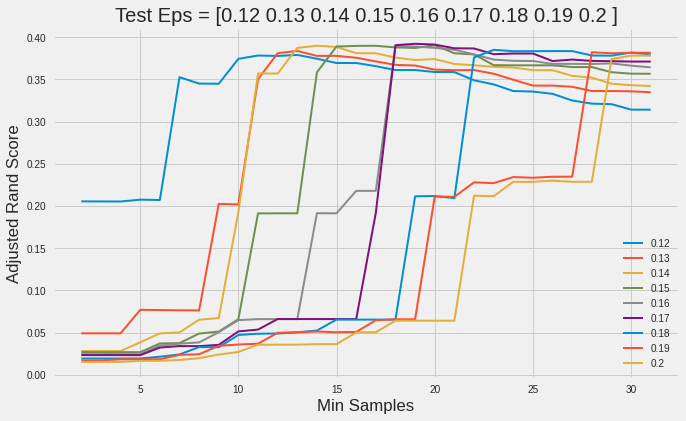

In [ ]:
title = f"Test Eps = {str(eps_range)}"
plt.style.use('fast')
plt.figure(figsize=(10,6))
for eps in eps_range:
  col_name = str(eps)
  plt.plot(df_test.min_sampl, df_test[col_name], label=col_name, linewidth=2)

plt.title(title)
plt.xlabel("Min Samples")
plt.ylabel("Adjusted Rand Score")
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

Here on the plot, we can see that the maximum value of the adjusted rand score is obtained with epsilon = 0.17 and min_samples = 18-19. Let's try to fit the DBSCAN model using these values of hyperparameters.

I also find in an empirical way that using chebyshev distance instead of euclidian gives better results so I decided to use one.

In [ ]:
epsilon = 0.17
min_sampl = 19
db = DBSCAN(eps=epsilon, min_samples=min_sampl, metric='chebyshev').fit(X_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
labels_true = df['kmeans_labels']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 7
Estimated number of noise points: 183
Homogeneity: 0.494
Completeness: 0.672
V-measure: 0.570
Adjusted Rand Index: 0.392
Adjusted Mutual Information: 0.567
Silhouette Coefficient: 0.022


The chosen combination of hypers gives us not the ideal but rather a good outcome: we have 7 clusters (that is quite close to the ground truth) and not so big a number of noise points. Adjusted Rand Score which I maximized on the hyperparameters tuning step is also quite good (~0.4). However other clustering metrics such as the Silhouette coefficient are not as good. But compared with the results of the Silhouette score which I obtained with other combinations of epsilon and min_sample (they always were negative) this above zero scores I can consider a good one.

In [ ]:
X['cluster'] = labels

Let's see how DBSCAN clusters look at the map and in Depth-Magnitude space:

In [ ]:
vizualize_clusters(X, 'dbscan', eps=epsilon, min_s=min_sampl)

Clusters interpritation:

*   Cluster 0: Shallow earthquake (up to 270m depth), low to high magnitude (5.8 - 6.9), South-West, West and North parts of the Ring of Fire, Alpide Belt (Guinea, Indonesia, Malaysia)
*   Cluster 1: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.5), Europe, Central and South Asia, Middle East, China.
*   Cluster 2: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.6), West cost of Central and South Americas, Caribean Region
*   Cluster 3: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.4), South of Atlantic Ocean.
*   Cluster 4: Deep earthquake (270m to 700m depth), low to moderate magnitude (5.8 - 6.2), South-West of the Pacific Ocean.
*   Cluster 5: Shallow earthquake (up to 270m depth), low to high magnitude (5.8 - 6.9), Arctic Ocean.
*   Cluster 6: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.1), West Cost of North America (US, Canada)  

As we can see all the outliers (noise points) are deep earthquakes. However DBSCAN managed to catch about half of them (Cluster 4), but the other half was left untouched.

In [ ]:
cluster_stat(X)

,id,quakes_qty,avg_depth,avg_magnitude,avg_lat,avg_lon
0,0,1399,54.459614,5.977055,8.509492,87.676097
1,1,221,31.479638,5.974208,39.963167,66.571448
2,2,249,54.481928,5.984337,-6.466466,-77.483976
3,3,53,51.150943,5.941509,-58.066981,-30.198679
4,4,39,505.102564,5.928205,-23.533333,-87.174615
5,5,22,0.000000,6.231818,72.900000,54.509091
6,6,12,12.750000,5.991667,42.155833,-122.785000


Insight got from the clusters statistics: Cluster 5: Avg Depth = 0. Location - Arctic, Novaya Zemlya archipelago. This place is notoriously known for nuclear weapons testing which was carried out there in 1955-1990. I assume that these points in the dataset refer to these nuclear explosions and not natural earthquakes.

Saving DBSCAN labels in the main dataframe:

In [ ]:
df['dbscan_labels'] = labels

### Agglomerative (Hierarchical) Clustering

The last algorithm I am going to use for earthquake clustering is Agglomerative or Hierarchical clustering. This method starts with every single point in the dataset and considers them as separate clusters. Then it goes through several steps and on each step algorithm agglomerates clusters - merge them with closest neighbor points and clusters. Finally, we got a single cluster containing all the points of the dataset. At the same time algorithm get a tree (called a dendrogram) which is a kind of scheme of how the entire cluster was built out of smaller clusters. We can use this dendrogram to choose how many clusters we want to get, and by passing this parameter to the clustering model we will get an expected result.  

In [ ]:
columns_to_clusterize = ['Depth', 'x', 'y', 'z', 'Richter']
X = df[columns_to_clusterize]

First, let's plot a dendrogram based on our data:

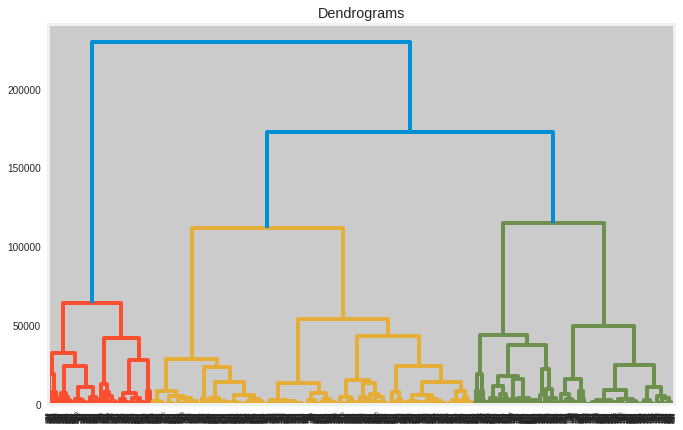

In [ ]:
plt.figure(figsize=(10, 7))
plt.style.use('fast')
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(X[], method='ward'))

Here we can see that good options for the numbers of clusters to divide our data to are 3, 5, and probably 6. Choosing bigger numbers we might get a mess of small clusters which might separate closely located points. So let's take 6 so to be closer to K-means labeling.

In [ ]:
X = df.copy()
k=6

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[columns_to_clusterize])
X_scaled_df = pd.DataFrame(X_scaled, columns=[columns_to_clusterize])

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=k)
y_agglomerative = agglomerative.fit_predict(X_scaled_df)

In [ ]:
X['cluster'] = pd.Series(y_agglomerative)

In [ ]:
vizualize_clusters(X, 'agg', k=6)

Here we can see that agglomerative clustering uses mainly geographical coordinates and depth as separating properties. Somehow magnitude was left out of the process, so we see clusters that have points from all the specters of magnitude but divided by geographical location.

Clusters Interpritation:

*   Cluster 0: Shallow earthquake (up to 270m depth), low to high magnitude (5.8 - 6.9), West, North-West, North, and North-East parts of the Ring of Fire.
*   Cluster 1: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.6), West, and South-West parts of the Ring of Fire, South of the Pacific Ocean.
*   Cluster 2: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.5), West of the Ring of Fire, Indonesia, Australia.
*   Cluster 3: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.6), Central and South Americas, Carribean, South of Atlantic Ocean, South of Africa, South of Indian Ocean.
*   Cluster 4: Shallow earthquake (up to 270m depth), low to moderate magnitude (5.8 - 6.5), Europa, Central and South Asia, Middle East, North Africa, China.
*   Cluster 5: Deep earthquake (270m to 700m depth), low to moderate magnitude (5.8 - 6.2), South-West of the Pacific Ocean.

Cluster statistics:

In [ ]:
cluster_stat(X)

,id,quakes_qty,avg_depth,avg_magnitude,avg_lat,avg_lon
0,0,476,42.804622,6.020798,43.246891,65.182332
1,1,548,56.598540,5.947993,-17.032464,62.091113
2,2,425,57.712941,5.968706,3.003600,125.584306
3,3,348,50.275862,5.970977,-16.482414,-56.250776
4,4,260,28.784615,5.989231,40.410077,61.423154
5,5,121,504.603306,5.959504,0.349008,39.534793


Saving agglomerative labels into the main dataframe:

In [ ]:
df['agglomerative_labels'] = X['cluster']

Clustering performance:

In [ ]:
n_clusters_ = len(set(y_agglomerative))

print('Number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, y_agglomerative))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, y_agglomerative))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, y_agglomerative))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, y_agglomerative))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, y_agglomerative))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, y_agglomerative))

Estimated number of clusters: 6
Homogeneity: 0.677
Completeness: 0.653
V-measure: 0.665
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.664
Silhouette Coefficient: 0.374


Silhouette Coefficient and Adjusted Rand Index look much better than DBSCAN's ones.

###Clustering quality metrics

In [ ]:
label_cols = ['kmeans_labels', 'dbscan_labels', 'agglomerative_labels']

In [ ]:
for col in label_cols:
    print(f'Adjusted MI score for {col} = {metrics.adjusted_mutual_info_score(labels_true, df[col])}')

Adjusted MI score for kmeans_labels = 1.0
Adjusted MI score for dbscan_labels = 0.5671239868470977
Adjusted MI score for agglomerative_labels = 0.6637912386846548


In [ ]:
for col in label_cols:
    print(f'Adjusted rand score for {col} = {adjusted_rand_score(labels_true, df[col])}')

Adjusted rand score for kmeans_labels = 1.0
Adjusted rand score for dbscan_labels = 0.39222487466669137
Adjusted rand score for agglomerative_labels = 0.5677275824557475


In [ ]:
for col in label_cols:
    print(f'Calinski Harabasz score for {col} = {calinski_harabasz_score(X_scaled, df[col])}')

Calinski Harabasz score for kmeans_labels = 834.9467734599269
Calinski Harabasz score for dbscan_labels = 230.8727680070438
Calinski Harabasz score for agglomerative_labels = 662.0734044188815


According to Calinski Harabasz's score which calculation doesn't require the ground truth (true labels), the best algorithm in our case is K-Means. It also gives a relatively high Silhouette score (0.35). The second one from a quality perspective is Agglomerative clustering, and the third is DBSCAN. Adjusted MI score and Adjusted rand score also show that Agglomerative clustering is closer to K-Means, which labels we set as ground truth, than DBSCAN. However, despite the metrics I liked DBSCAN results more than AGglomerative ones, it catches some small but distinct clusters that other algorithms don't.    

# Conclusions
In the process of completing this task, I build three different models in order to cluster data on earthquakes containing position coordinates, focal depth, and magnitude. <br>
First, I did EDA and studied the distribution of the given variables, and the correlation between them.
Then I performed the dimensionality reduction technic - PCA in order to plot multidimensional data onto a 2d plot and study if there are visible clusters or not (they are). <br>
The algorithms of clustering I used are:<br>

*   K-Means
*   DBSCAN
*   Agglomerative clustering

For all of the algorithms, I performed an estimation of the best parameters (number of clusters in K-Means and Agglomerative) and hyperparameters (epsilon and min_sample in DBSCAN). I also plotted the results of clustering algorithms in various sections, and estimate performance metrics for every method.

The best results, according to metrics, were obtained by K-Means with k=6, and the worst - with DBSCAN. But subjectively DBSCAN is also an interesting algorithm that gives some unexpected results. I believe that it could be better tuned to get better results in terms of metrics.